In [57]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Activation, Input, Layer, MultiHeadAttention, LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import warnings
warnings.filterwarnings("ignore")


# Image Captioning in 30K dataset

In [2]:
image_path = 'flickr30k_images'

In [3]:
df = pd.read_csv('results.csv',delimiter='|')

In [4]:
df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
df.columns = df.columns.str.strip()

In [6]:
df['comment'][0]

' Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [7]:
df.drop(columns=['comment_number'],inplace=True)

In [10]:
def read_img(path,img_size=300):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df,max_images = 15):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(max_images):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        img = read_img(f"flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(img)
        plt.title("\n".join(wrap(temp_df.comment[i],20)))
        plt.axis('off')

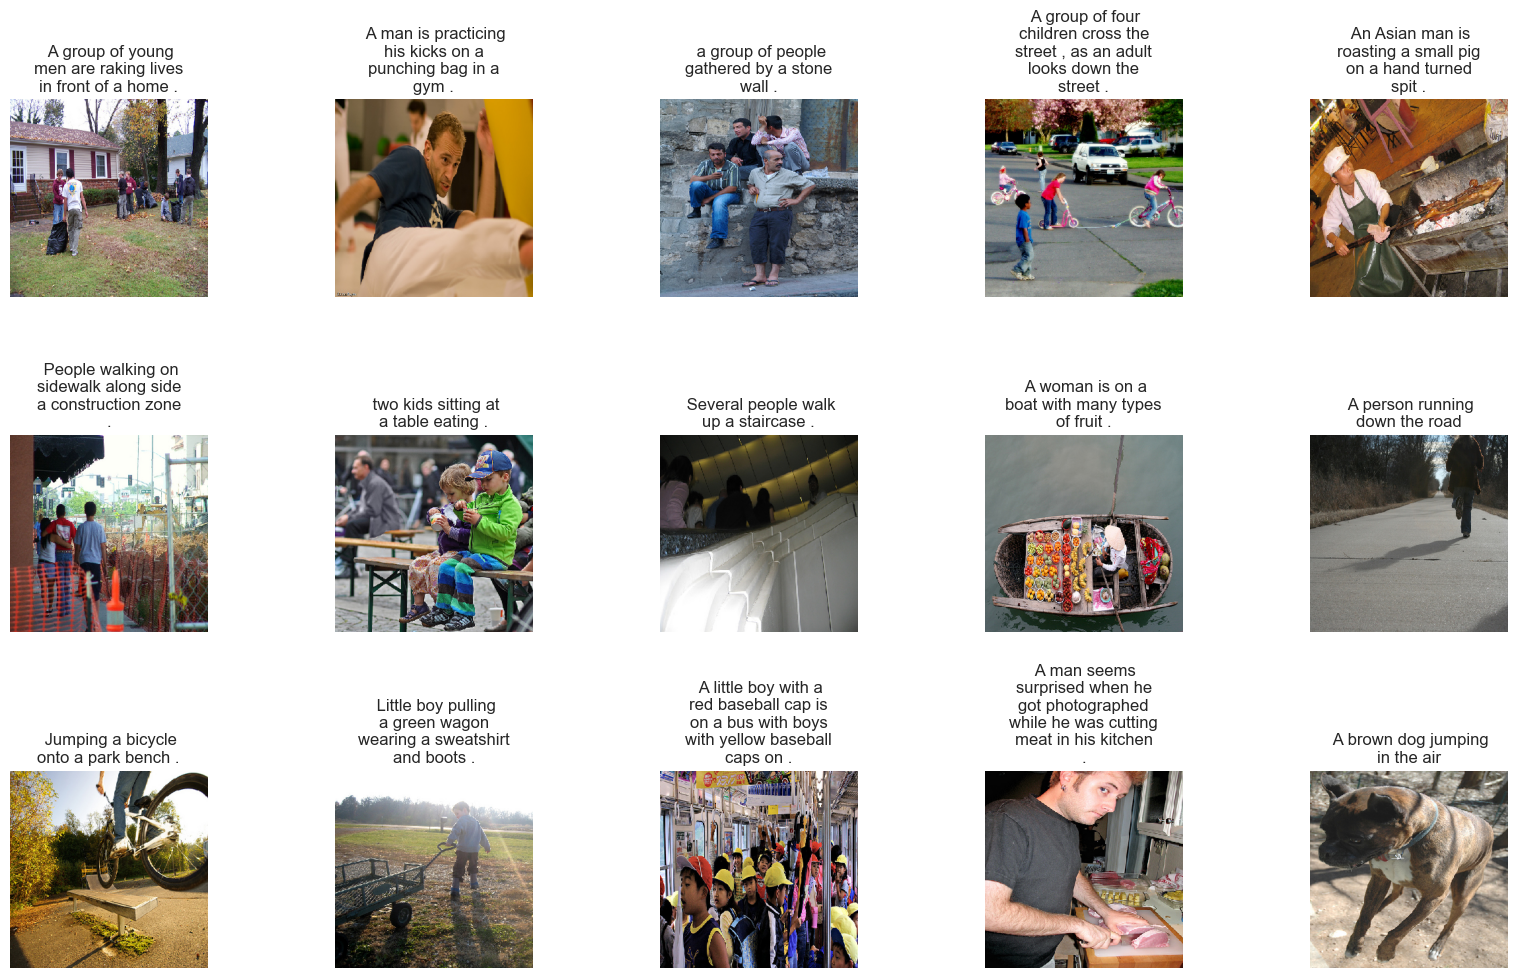

In [11]:
display_images(df.sample(15))

In [12]:
df['comment'] = df['comment'].astype(str)

## Caption Text Basic Preprocessing

In [13]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x : x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['comment'] = "startseq " + data['comment'] + " endseq"
    return data

In [14]:
df = text_preprocessing(df)

In [15]:
captions = df['comment'].tolist()

In [17]:
captions[1:10]

['startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

## Tokenisation of the text

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

## Data Spliting

In [19]:
images = df['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)

train_images = images[:split_index]
test_images = images[split_index:]

train = df[df['image_name'].isin(train_images)]
test = df[df['image_name'].isin(test_images)]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## Image Feature Engineering and Extraction

In [41]:
model = DenseNet201()
Feature_extracted = Model(inputs = model.input,outputs = model.layers[-2].output)

img_size =  224
features = {}
for image in tqdm(df['image_name'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = Feature_extracted.predict(img,verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [1:08:36<00:00,  7.72it/s]


In [43]:
import pickle
file = "features.pickle"

with open(file,'wb') as f:
    pickle.dump(features,f)

In [42]:
print("Features dictionary saved successfully.")

Features dictionary saved successfully.


In [24]:
import pickle
feature = pickle.load(open('features.pickle','rb'))

In [36]:
(feature['1000092795.jpg'])

array([[1.1481965e-04, 7.8771019e-04, 1.2043347e-03, ..., 9.2044408e-03,
        2.1380291e+00, 1.2945100e+00]], dtype=float32)

"# Data Generator

In [28]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# Modeling

In [89]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        transformer_output = self.layernorm2(out1 + ffn_output)
        
        output = self.global_avg_pool(transformer_output)
        
        return output

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


In [90]:
input1 = Input(shape=(1920,)) # length of feature vector of image
input2 = Input(shape=(max_length)) # length of maximum token in the caption

img_feature = Dense(100,activation='relu')(input1)
img_feature_reshape = Reshape((1,100),input_shape=(100,))(img_feature)

sentence_features = Embedding(vocab_size,100,mask_zero=False)(input2)
merged = concatenate([img_feature_reshape,sentence_features],axis=1)
transformer_block = TransformerBlock(embed_dim=100,num_heads=4,ff_dim=64)
x = transformer_block(merged,training=True)
x = LayerNormalization(epsilon=1e-6)(x)
x = Dropout(0.3)(x)
x = add([x,img_feature])
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
output = Dense(vocab_size,activation='softmax')(x)

In [97]:
caption_model = Model(inputs=[input1,input2],outputs = output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])

In [92]:
caption_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1920)]       0           []                               
                                                                                                  
 dense_50 (Dense)               (None, 100)          192100      ['input_25[0][0]']               
                                                                                                  
 input_26 (InputLayer)          [(None, 74)]         0           []                               
                                                                                                  
 reshape_12 (Reshape)           (None, 1, 100)       0           ['dense_50[0][0]']               
                                                                                            

# Generating the data

In [93]:
train_generator = CustomDataGenerator(df=train,X_col='image_name',y_col='comment',batch_size=24,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=feature)

validation_generator = CustomDataGenerator(df=test,X_col='image_name',y_col='comment',batch_size=24,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=feature)

# Parameters

In [94]:
model_name = 'model_30k.h5'

checkpoint = ModelCheckpoint(model_name,monitor='val_loss',mode="min",save_best_only=True,verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=5,verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.2,min_lr=0.00000001)

# Fit the model

In [ ]:
history = caption_model.fit(train_generator,epochs=20,validation_data=validation_generator,callbacks=[checkpoint,earlystopping,learning_rate_reduction],steps_per_epoch=1000)

# Error Plot

In [81]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 2000x800 with 0 Axes>

# Token to word address

In [82]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

# Prediction Function

In [83]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = caption_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

# Testing The model

In [84]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [87]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image_name']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image_name'], tokenizer, max_length, feature)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 22ms/step


In [96]:
samples

,image_name,comment,caption
0,82680989.jpg,startseq the woman holding up four fingers has the attention of the young man in the blue dress shirt endseq,startseq woman is sitting at table in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the endseq
1,7186836768.jpg,startseq young men playing soccer with green sports field in the background endseq,startseq two men playing in the the the the field endseq
2,6887015851.jpg,startseq two young boys pose with puppy for family picture endseq,startseq woman in white shirt is sitting in chair endseq
3,86109631.jpg,startseq woman in red leans her head on the shoulder of the woman next to her endseq,startseq young girl in blue shirt is playing in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the day endseq
4,570520724.jpg,startseq man in yellow shirt and hard hat is carrying tree branch endseq,startseq man in blue shirt is playing in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the day the the endseq
5,5542771977.jpg,startseq man eats food in front of street-side restaurant endseq,startseq man in white shirt is sitting on the the the the the the the the street endseq
6,6209037268.jpg,startseq two girls drawing sailboats with chalk on the side of concrete endseq,startseq two men are sitting on the the the the the the the the the the the the the the the the the the the the day endseq
7,630476551.jpg,startseq girl plays on the shore at the beach endseq,startseq two boys are playing in the the the the the the the the the the the beach endseq
8,6063730184.jpg,startseq young child is enjoying the water and rock scenery with their dog endseq,startseq two men are playing in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the day endseq
9,7915147578.jpg,startseq three people are playing water volleyball in pool endseq,startseq two men are playing in the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the day endseq


# Display the predicted caption

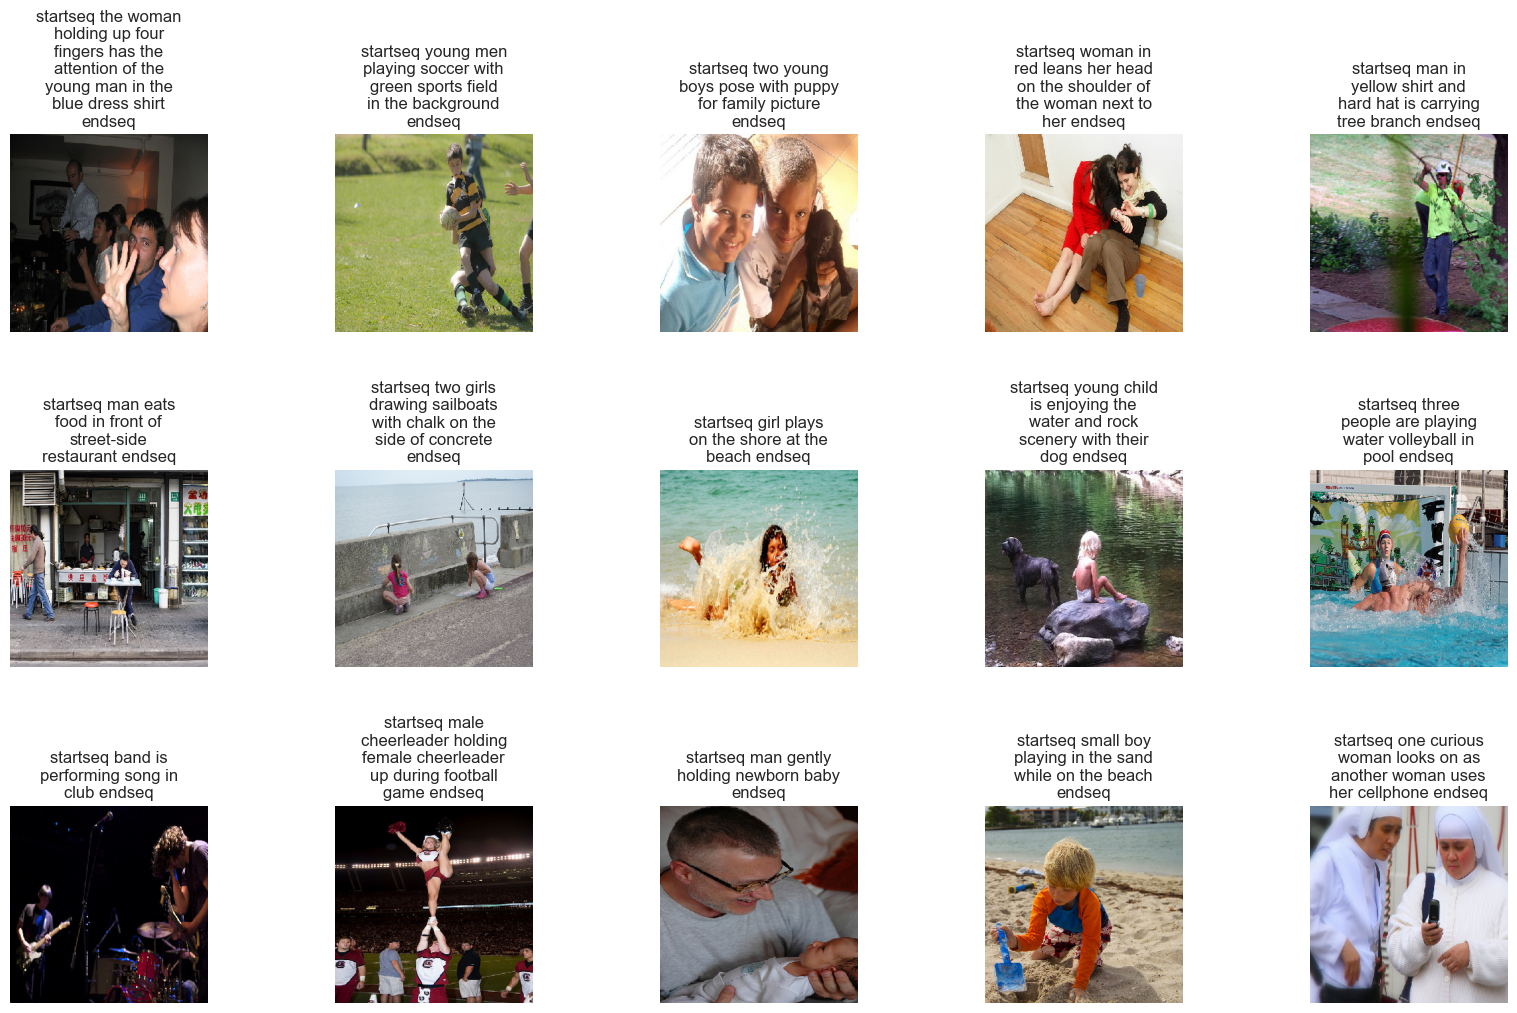

In [88]:
display_images(samples)